<a href="https://colab.research.google.com/github/AmeerAliSaleem/MA4J5_Project/blob/main/Ameer_Ali_Saleem_MA4J5_Main_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MA4J5 Project: Predicting Amazon Review Scores with neural networks
---
### Ameer Ali Saleem

A Python notebook containing the Python code to support my MA4J5 report. Please note that this notebook has been written in Google Colab: this allows for the use of the TensorFlow package without requiring a direct installation (which would take roughly 1.1GB of storage). If you do not have TensorFlow installed, please click on the "Open in Colab" link at the top of the notebook.

# Imports and checks

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import regex as re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Our goal is to build a neural network to predict the rating (out of 5 stars) of an input Amazon Kindle review. The data used in this project can be found at <a href="https://nijianmo.github.io/amazon/index.html">this link</a>. In this notebook, we use the undersampled dataset, which should help alleviate the issue of class imbalance.

In [2]:
df = pd.read_csv("kindle_balanced.csv")

In [3]:
df.head()

,Unnamed: 0,overall,reviewTime,reviewText,summary
0,0,4.0,"08 19, 2014","Very helpful on healing plants, could read it ...",Good reference book for anyone wanting to know...
1,1,4.0,"08 23, 2014",Good read,Four Stars
2,2,3.0,"07 24, 2013",Some of the chapters in this book were very us...,"Some good, some not so....."
3,3,5.0,"02 23, 2014",L.O.V.E.D!!!!!! I absolutely love this erotic...,L.O.V.E.D
4,4,4.0,"11 24, 2013",I am not sure why I got sucked in to this from...,very good start..


In [4]:
df = df.drop(columns="Unnamed: 0")

In [5]:
df.head()

,overall,reviewTime,reviewText,summary
0,4.0,"08 19, 2014","Very helpful on healing plants, could read it ...",Good reference book for anyone wanting to know...
1,4.0,"08 23, 2014",Good read,Four Stars
2,3.0,"07 24, 2013",Some of the chapters in this book were very us...,"Some good, some not so....."
3,5.0,"02 23, 2014",L.O.V.E.D!!!!!! I absolutely love this erotic...,L.O.V.E.D
4,4.0,"11 24, 2013",I am not sure why I got sucked in to this from...,very good start..


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181465 entries, 0 to 181464
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     181465 non-null  float64
 1   reviewTime  181465 non-null  object 
 2   reviewText  181439 non-null  object 
 3   summary     181395 non-null  object 
dtypes: float64(1), object(3)
memory usage: 5.5+ MB


# Text Preprocessing

In [7]:
type(df["reviewText"].values)

numpy.ndarray

In [8]:
print(type(df["reviewText"].iloc[0]))

<class 'str'>


In [9]:
df["reviewText"] = df["reviewText"].astype(str)

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
reviews_cleaned = []

for i in range(len(df["reviewText"])):
  reviews_raw = df["reviewText"].iloc[i]
  reviews_edit_1 = reviews_raw.lower()
  reviews_edit_2 = re.sub(r"[^a-zA-Z0-9\s\.]", "", reviews_edit_1) # Filter punctuation
  # reviews_edit_3 = re.sub(" \.|\. ", "", reviews_edit_2) # Get rid of fullstops that are outside of words
  reviews_cleaned.append(reviews_edit_2.strip()) # remove unnecessary whitespace and append to list of cleaned reviews


# vectorised code
# reviews_edit_1 = df["reviewText"].str.lower() # Convert all reviewText to lowercase
# reviews_edit_2 = reviews_edit_1.str.replace(r"[^a-zA-Z0-9\s\.]", "") # Filter that punctuation g
# reviews_cleaned = reviews_edit_2.str.strip().tolist() # Remove unnecessary whitespace

In [12]:
# remove stopwords from the cleaned list
filtered_reviews = [
    ' '.join(word for word in sentence.split() if word.lower() not in stopwords)
    for sentence in reviews_cleaned
]

In [15]:
# take a look at some sample data
reviews_cleaned[:5]

['very helpful on healing plants could read it only for a short time then digest it.\ngood book to have around.',
 'good read',
 'some of the chapters in this book were very useful.  others not so much.  the good thing about these dummies books is that you dont have to read every chapter.  you can read only what interests you so it wasnt a problem for me.  perhaps others with wider fields of interest will find it much more useful.  i would try another book like this again if it had different subjects.',
 'l.o.v.e.d  i absolutely love this erotic romance by scarlet wolfe hot and great story line downloading one plea as soon as i finish my review of one urge  damon will frustrate you but you cant help but fall in love with him and then alayna is an awesome heroine that you cant help but love i cant wait to read more of their story ... i am sooo hoping for an hea  just a heads up  one plea can be found under erotica on amazon',
 'i am not sure why i got sucked in to this from the first pa

In [16]:
# compare the above with stopwords removed
filtered_reviews[:5]

['helpful healing plants could read short time digest it. good book around.',
 'good read',
 'chapters book useful. others much. good thing dummies books dont read every chapter. read interests wasnt problem me. perhaps others wider fields interest find much useful. would try another book like different subjects.',
 'l.o.v.e.d absolutely love erotic romance scarlet wolfe hot great story line downloading one plea soon finish review one urge damon frustrate cant help fall love alayna awesome heroine cant help love cant wait read story ... sooo hoping hea heads one plea found erotica amazon',
 'sure got sucked first page needed know world. story line interesting easy fall into. agree reviews think needed little detail world life live moment. get back ground dystopian world however really good fast read kept wanting disappointed']

## Train-test split

In [17]:
labels = list(df["overall"])

# Shuffle the data.

filtered_reviews, labels = zip(*random.sample(list(zip(filtered_reviews,labels)), len(filtered_reviews)))
filtered_reviews = list(filtered_reviews)
labels = list(labels)

# Train-test split (80:20)

trainsize = int(len(filtered_reviews)*0.8)

train_reviews, train_labels = filtered_reviews[:trainsize], labels[:trainsize]
test_reviews, test_labels = filtered_reviews[trainsize:], labels[trainsize:]

In [18]:
# Check distribution reviews (1,2,3,4,5) in the training set

print("TRAINING SET")
print("Number of reviews to use for training is: {}.".format(len(train_labels)))
print("Number of 5-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==5),100*sum(np.array(train_labels)==5)/len(train_labels)))
print("Number of 4-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==4),100*sum(np.array(train_labels)==4)/len(train_labels)))
print("Number of 3-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==3),100*sum(np.array(train_labels)==3)/len(train_labels)))
print("Number of 2-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==2),100*sum(np.array(train_labels)==2)/len(train_labels)))
print("Number of 1-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==1),100*sum(np.array(train_labels)==1)/len(train_labels)))

TRAINING SET
Number of reviews to use for training is: 145172.
Number of 5-star reviews is: 28992 (or 20.0%).
Number of 4-star reviews is: 29115 (or 20.1%).
Number of 3-star reviews is: 29009 (or 20.0%).
Number of 2-star reviews is: 28919 (or 19.9%).
Number of 1-star reviews is: 29137 (or 20.1%).


## Tokenisation

The word tokenizer provided by the Keras package will be able to deal with full stops for us, e.g. "missing." and "missing" will be treated as the same token.

Now for the tokenisation. In particular, we must conduct this separately on the training and test sets. The reason for this is due to so-called "data leakage": we do not want to introduce any elements of the testing data to the network before or during training. These two sets should be kept as separate as possible.

In [19]:
# max size of our vectorised corpus
vocab_size = 20000

# maximum allowed length for each vectorised sentence into our neural network
max_length = 50

# Tokenization
# OOV token deals with words that our tokenizer has not seen before (e.g. in the test set)
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_reviews)
word_index = tokenizer.word_index

# print out our dictionary of vectors
# print(word_index)


train_sequences = tokenizer.texts_to_sequences(train_reviews)
test_sequences = tokenizer.texts_to_sequences(test_reviews)

# padding sequences to standardise the input size of each row of data for our NN
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [20]:
print(len(word_index))

104903


# Model Building and Evaluation

We now experiment with a variety of neural network architectures, with the aim of maximising the accuracy of our model on the *testing set*.

In [21]:
# function to plot and analyse the learning of each neural network
def learning_curve(history):
    plt.figure(figsize=(10,12))

    # Loss subplot.
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    # Accuracy subplot.
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

In [22]:
# more model parameters
embedding_dim = 16
num_epochs = 15

In [29]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [30]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            320000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 5)                 125       
                                                                 
Total params: 320533 (1.22 MB)
Trainable params: 320533 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
type(train_labels[0])

float

In [32]:
train_labels_int = [int(x) for x in train_labels]
test_labels_int = [int(x) for x in test_labels]

In [33]:
type(train_labels_int[0])

int

In [34]:
history = model1.fit(train_padded, tf.one_hot(train_labels_int,5), epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
4537/4537 - 31s - loss: 1.2552 - accuracy: 0.2138 - val_loss: 1.2758 - val_accuracy: 0.2032 - 31s/epoch - 7ms/step
Epoch 2/15
4537/4537 - 29s - loss: 2.5352 - accuracy: 0.2055 - val_loss: 1.8439 - val_accuracy: 0.2129 - 29s/epoch - 6ms/step
Epoch 3/15
4537/4537 - 33s - loss: 6.3784 - accuracy: 0.2029 - val_loss: 7.1463 - val_accuracy: 0.1972 - 33s/epoch - 7ms/step
Epoch 4/15
4537/4537 - 30s - loss: 12.6696 - accuracy: 0.2008 - val_loss: 10.0517 - val_accuracy: 0.1972 - 30s/epoch - 7ms/step
Epoch 5/15
4537/4537 - 31s - loss: 21.3433 - accuracy: 0.2000 - val_loss: 43.7924 - val_accuracy: 0.1972 - 31s/epoch - 7ms/step
Epoch 6/15
4537/4537 - 28s - loss: 29.6045 - accuracy: 0.2000 - val_loss: 49.6859 - val_accuracy: 0.1978 - 28s/epoch - 6ms/step
Epoch 7/15
4537/4537 - 29s - loss: 41.0817 - accuracy: 0.1991 - val_loss: 15.1670 - val_accuracy: 0.2032 - 29s/epoch - 6ms/step
Epoch 8/15
4537/4537 - 27s - loss: 53.3397 - accuracy: 0.2014 - val_loss: 87.6250 - val_accuracy: 0.2032 - 27s

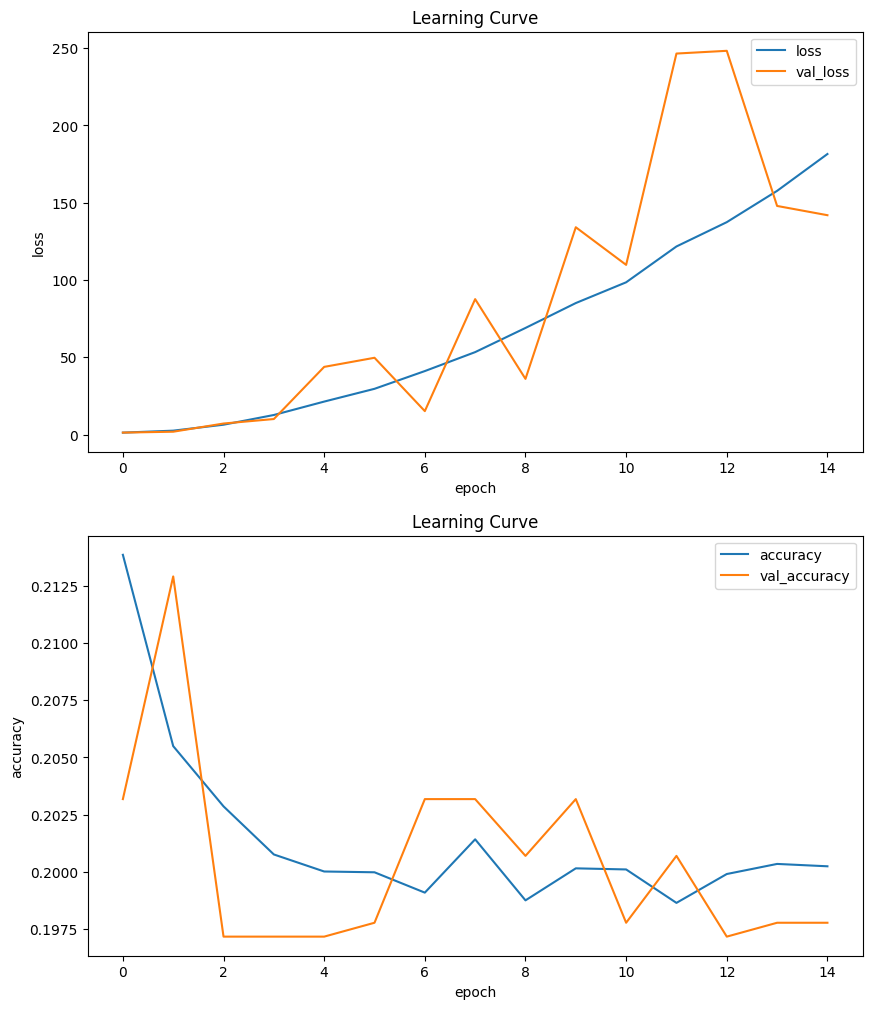

In [35]:
learning_curve(history)

In [46]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(5, activation='softmax')
])
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [47]:
history2 = model2.fit(train_padded, tf.one_hot(train_labels_int,5), epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
4537/4537 - 52s - loss: 1.0532 - accuracy: 0.3578 - val_loss: 0.9927 - val_accuracy: 0.3878 - 52s/epoch - 12ms/step
Epoch 2/15
4537/4537 - 32s - loss: 0.9711 - accuracy: 0.3911 - val_loss: 0.9539 - val_accuracy: 0.4059 - 32s/epoch - 7ms/step
Epoch 3/15
4537/4537 - 32s - loss: 0.9450 - accuracy: 0.3951 - val_loss: 0.9480 - val_accuracy: 0.3684 - 32s/epoch - 7ms/step
Epoch 4/15
4537/4537 - 31s - loss: 0.9307 - accuracy: 0.3958 - val_loss: 0.9335 - val_accuracy: 0.3653 - 31s/epoch - 7ms/step
Epoch 5/15
4537/4537 - 29s - loss: 0.9204 - accuracy: 0.3996 - val_loss: 0.9213 - val_accuracy: 0.3892 - 29s/epoch - 6ms/step
Epoch 6/15
4537/4537 - 31s - loss: 0.9148 - accuracy: 0.3968 - val_loss: 0.9073 - val_accuracy: 0.4130 - 31s/epoch - 7ms/step
Epoch 7/15
4537/4537 - 31s - loss: 0.9099 - accuracy: 0.3970 - val_loss: 0.9075 - val_accuracy: 0.4003 - 31s/epoch - 7ms/step
Epoch 8/15
4537/4537 - 30s - loss: 0.9044 - accuracy: 0.3984 - val_loss: 0.9187 - val_accuracy: 0.3694 - 30s/epoch - 

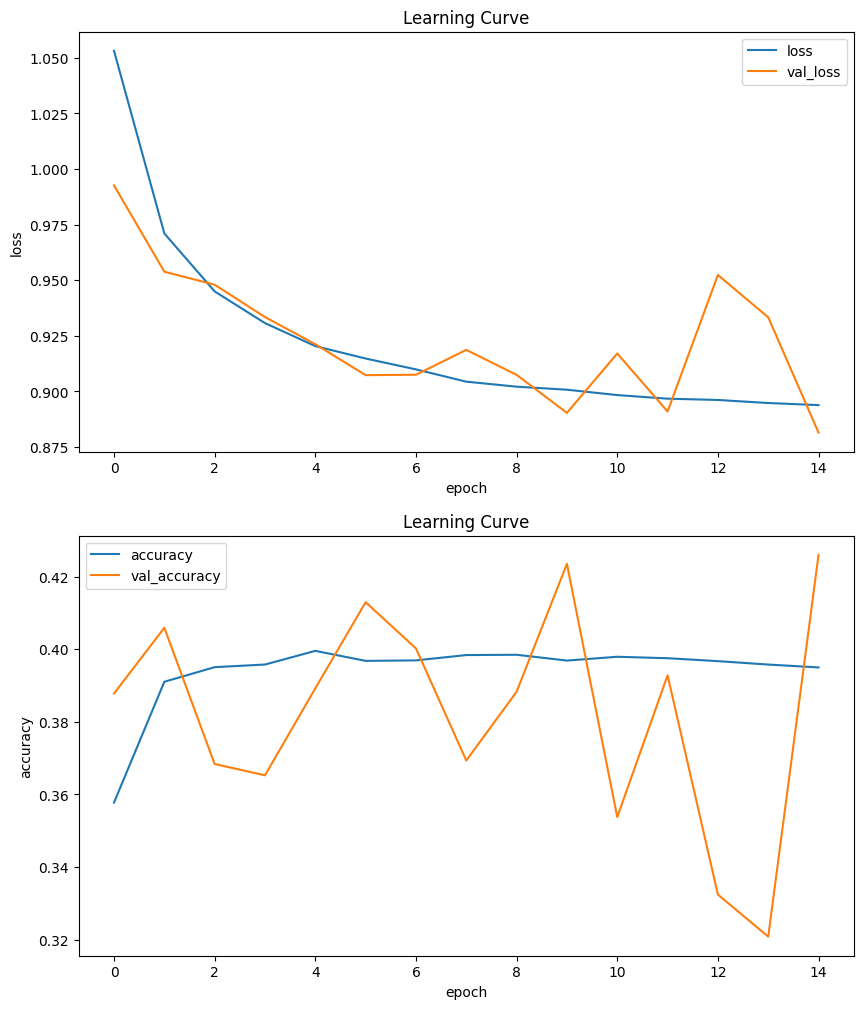

In [48]:
learning_curve(history2)

# Model Applicaton

# Model Extensions